# Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Perform feature selection on the agglomorated matrix, dropping redundant features and finding the  optimum number of features. (Multivariate analysis - through a wrapper approach)
* Feed dataset into a number of machine learning models

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

### Module Installation and Importing Libraries

https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

In [694]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math

scipy: 0.19.1
numpy: 1.15.2
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.18.1
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Read data from file into pandas dataframes

In [695]:
tpcds='TPCDS1' # Schema upon which to operate test
low_quartile_limit = 0 # Lower Quartile threshold to detect outliers
upper_quartile_limit = 1 # Upper Quartile threshold to detect outliers
lag=1 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
test_split=.3 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample=100 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA'] # Denotes which label to use for time series experiments
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Pivoting tables and changing matrix shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [696]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 162
REP_HIST_SYSSTAT: 1179

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (4014, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (4018, 162)
Table [REP_HIST_SYSSTAT] - (4019, 1179)


### Merging frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [697]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df, on='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df, on='SNAP_ID')
print(df.shape)

(4014, 1416)


### Dealing with empty values

In [698]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\nFeatures ' + str(len(df.columns)) + ': ' + str(get_na_columns(df=df,headers=df.columns)))
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
df = fill_na(df=df)

N/A Columns


Features 1416: []


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [699]:
df.astype('float32', inplace=True)

SNAP_ID          DBID  INSTANCE_NUMBER  PLAN_HASH_VALUE  OPTIMIZER_COST  \
0      2367.0  2.239092e+11             85.0     1.640461e+11    8.784000e+03   
1      2368.0  2.502514e+11             95.0     1.949895e+11    4.611440e+05   
2      2369.0  2.397145e+11             91.0     1.945993e+11    3.901824e+12   
3      2370.0  2.449830e+11             93.0     1.900085e+11    9.329020e+05   
4      2371.0  3.003017e+11            114.0     2.486438e+11    3.901826e+12   
5      2372.0  2.897648e+11            110.0     2.354967e+11    3.901826e+12   
6      2373.0  2.844964e+11            108.0     2.342371e+11    2.914662e+06   
7      2374.0  2.818621e+11            107.0     2.312295e+11    3.901827e+12   
8      2375.0  2.081038e+11             79.0     1.565703e+11    4.520200e+04   
9      2376.0  2.239092e+11             85.0     1.643388e+11    1.281300e+04   
10     2377.0  2.950333e+11            112.0     2.381013e+11    3.901826e+12   
11     2378.0  2.739595e+11            104.0     2.214064e+11    3.901826e+12   
12     2379.0  2.844964e+11            108.0     2.331133e+11    1.884528e+06   
13     2380.0  2.976675e+11            113.0     2.341520e+11    3.901826e+12   
14     2381.0  2.765937e+11            105.0     2.237029e+11    2.025843e+06   
15     2382.0  2.186407e+11             83.0     1.563091e+11    5.661000e+03   
16     2383.0  2.107381e+11             80.0     1.778926e+11    1.469900e+04   
17     2384.0  2.291776e+11             87.0     2.004337e+11    4.295240e+05   
18     2385.0  2.476172e+11             94.0     2.027203e+11    3.783072e+12   
19     2386.0  2.265434e+11             86.0     1.830992e+11    1.105560e+05   
20     2387.0  2.476172e+11             94.0     1.980640e+11    1.111870e+05   
21     2388.0  2.449830e+11             93.0     1.985481e+11    2.312370e+05   
22     2389.0  2.792279e+11            106.0     2.383240e+11    3.783073e+12   
23     2390.0  2.739595e+11            104.0     2.250402e+11    3.783074e+12   
24     2391.0  2.449830e+11             93.0     1.951456e+11    2.059302e+06   
25     2392.0  2.976675e+11            113.0     2.449747e+11    3.783073e+12   
26     2393.0  2.739595e+11            104.0     2.387717e+11    3.783073e+12   
27     2394.0  2.607883e+11             99.0     2.218770e+11    1.696816e+06   
28     2395.0  2.844964e+11            108.0     2.363035e+11    3.783073e+12   
29     2396.0  2.765937e+11            105.0     2.354152e+11    3.783073e+12   
...       ...           ...              ...              ...             ...   
3984   6351.0  1.712247e+11             65.0     9.318067e+10    3.249300e+04   
3985   6352.0  2.449830e+11             93.0     1.953485e+11    3.600029e+12   
3986   6353.0  2.528857e+11             96.0     2.084524e+11    3.600029e+12   
3987   6354.0  2.713252e+11            103.0     2.283273e+11    2.986485e+06   
3988   6355.0  2.871306e+11            109.0     2.283956e+11    3.600029e+12   
3989   6356.0  1.633220e+11             62.0     9.322775e+10    1.979900e+04   
3990   6357.0  1.211744e+11             46.0     9.914032e+10    4.446700e+04   
3991   6358.0  2.212750e+11             84.0     2.007148e+11    3.166460e+05   
3992   6359.0  1.975669e+11             75.0     1.435679e+11    3.600027e+12   
3993   6360.0  1.870300e+11             71.0     1.285695e+11    9.633990e+05   
3994   6361.0  2.713252e+11            103.0     2.270081e+11    3.600029e+12   
3995   6362.0  2.739595e+11            104.0     2.276946e+11    3.600029e+12   
3996   6363.0  2.871306e+11            109.0     2.254251e+11    3.600029e+12   
3997   6364.0  1.712247e+11             65.0     1.004643e+11    2.633500e+04   
3998   6365.0  2.054696e+11             78.0     1.550605e+11    3.600028e+12   
3999   6366.0  2.634226e+11            100.0     2.201761e+11    3.600029e+12   
4000   6367.0  2.660568e+11            101.0     2.250305e+11    3.600029e+12   
4001   6368.0  2.897648e+11          

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [700]:
y_label.append('SNAP_ID')
y_df = df[y_label]
del y_label[-1]
df.drop(columns=y_label, inplace=True)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(df.shape))
#
# Merging labels and features in respective order
df = pd.merge(y_df,df,on='SNAP_ID',sort=False,left_on=None, right_on=None)
print('Merged Labels + Vectors: ' + str(df.shape))
print(df.head())

Label ['CPU_TIME_DELTA', 'OPTIMIZER_COST', 'EXECUTIONS_DELTA', 'ELAPSED_TIME_DELTA'] shape: (4014, 5)
Feature matrix shape: (4014, 1412)
Merged Labels + Vectors: (4014, 1416)
   CPU_TIME_DELTA  OPTIMIZER_COST  EXECUTIONS_DELTA  ELAPSED_TIME_DELTA  \
0       101557414    8.784000e+03            7839.0           819339800   
1        64750404    4.611440e+05            3735.0           161339018   
2        35639792    3.901824e+12            3165.0            37055987   
3        73819233    9.329020e+05            1784.0            74364511   
4       667030931    3.901826e+12           20277.0           677473106   

   SNAP_ID          DBID  INSTANCE_NUMBER  PLAN_HASH_VALUE  \
0     2367  223909182205               85     164046116807   
1     2368  250251438935               95     194989522751   
2     2369  239714536243               91     194599335925   
3     2370  244982987589               93     190008545198   
4     2371  300301726722              114     248643769496   

 

### Feature Normalization

In [701]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized_values = scaler.fit_transform(df.values)
#
df = pd.DataFrame(data=df_normalized_values, columns=df.columns)
del df_normalized_values
print(str(df.shape))
print(df.head())

(4014, 1416)
   CPU_TIME_DELTA  OPTIMIZER_COST  EXECUTIONS_DELTA  ELAPSED_TIME_DELTA  \
0        0.065297    6.951474e-10          0.313208            0.478615   
1        0.041058    7.235806e-08          0.145335            0.092718   
2        0.021888    6.181274e-01          0.122019            0.019830   
3        0.047030    1.470940e-07          0.065530            0.041710   
4        0.437680    6.181276e-01          0.821982            0.395415   

    SNAP_ID    DBID  INSTANCE_NUMBER  PLAN_HASH_VALUE  \
0  0.000000  0.5750           0.5750         0.479923   
1  0.000249  0.7000           0.7000         0.646057   
2  0.000498  0.6500           0.6500         0.643962   
3  0.000748  0.6750           0.6750         0.619314   
4  0.000997  0.9375           0.9375         0.934124   

   OPTIMIZER_ENV_HASH_VALUE  SHARABLE_MEM                 ...                  \
0                  0.334206      0.011067                 ...                   
1                  0.559831    

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

In [702]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n_in=1):
    if n_in == 0:
        return df
    df = data
    headers = df.columns
    dropped_headers = []
    for header in headers:
        if "(t)" in header:
            dropped_headers.append(header)
    #
    for i in range(1,n_in):
        for header in headers:
            if "(t-"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1)        
#
# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, 1)
#
# Seperate labels from features
y_df_column_names = shifted_df.columns[len(df.columns):len(df.columns) + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nVectors')
print(y_df.columns)
print(y_df.shape)
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n_in=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)


-------------
Features
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var1407(t)', 'var1408(t)', 'var1409(t)', 'var1410(t)', 'var1411(t)',
       'var1412(t)', 'var1413(t)', 'var1414(t)', 'var1415(t)', 'var1416(t)'],
      dtype='object', length=2828)
(4013, 2828)

-------------
Vectors
Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'], dtype='object')
(4013, 4)

-------------
Features After Time Shift
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var1407(t-1)', 'var1408(t-1)', 'var1409(t-1)', 'var1410(t-1)',
       'var1411(t-1)', 'var1412(t-1)', 'var1413(t-1)', 'var1414(t-1)',
       'var1415(t-1)', 'var1416(t-1)'],
      dtype='object', length=1416)
(4013, 1416)


### Bucket Function

Takes a value and converts it into a bucket value (of 10 values)

In [703]:
def discretize_value(amount):
    """
    Assumes that amount is decimal value. If so, return 1st value after decimal.
    """
    amount = float(amount)
    if amount < 0:
        amount = 0.01
    if amount > 1:
        amount = 0.99
    amount = str(amount)
    amount = amount.split('.')
    amount = amount[1][0]
    return float(amount)
#print(discretize_value(amount=0.26))

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(2809, 1416)] Type - <class 'numpy.ndarray'>
y_train shape [(2809, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(602, 1416)] Type - <class 'numpy.ndarray'>
y_validate shape [(602, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(602, 1416)] Type - <class 'numpy.ndarray'>
y_test shape [(602, 4)] Type - <class 'numpy.ndarray'>


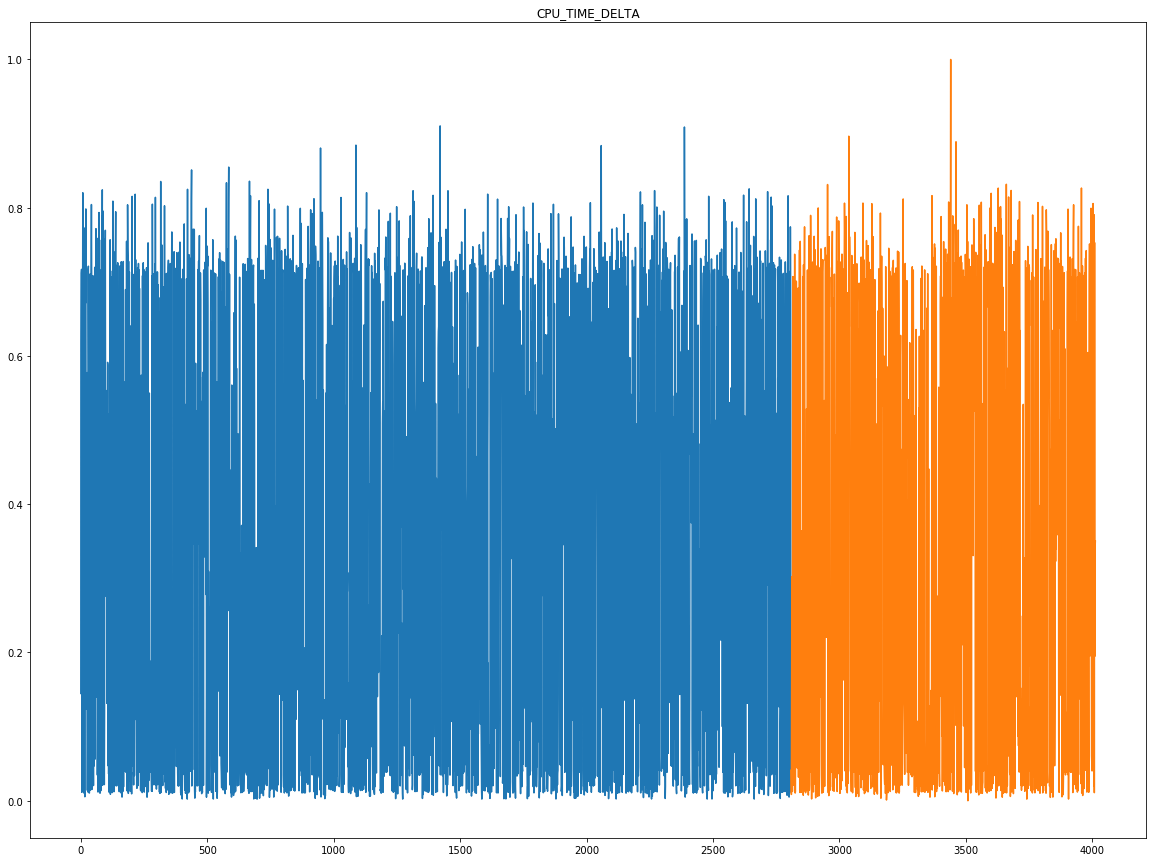

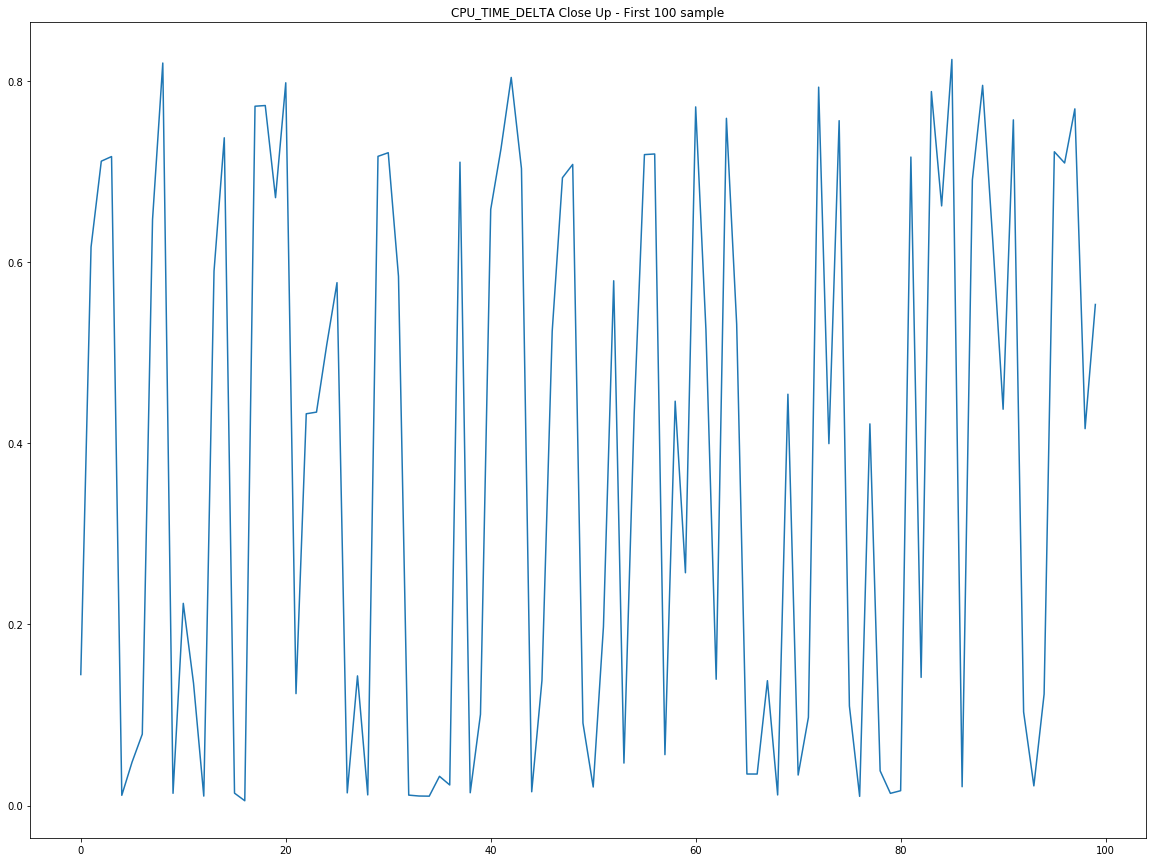

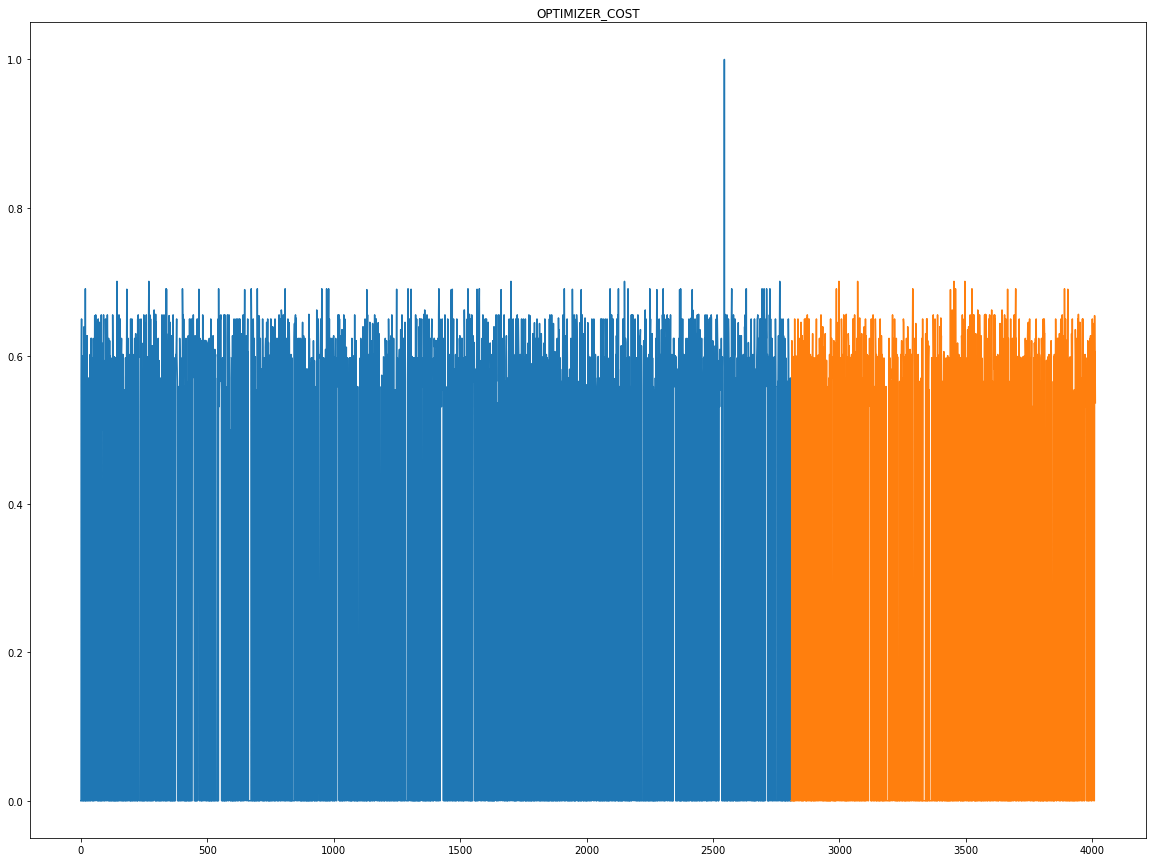

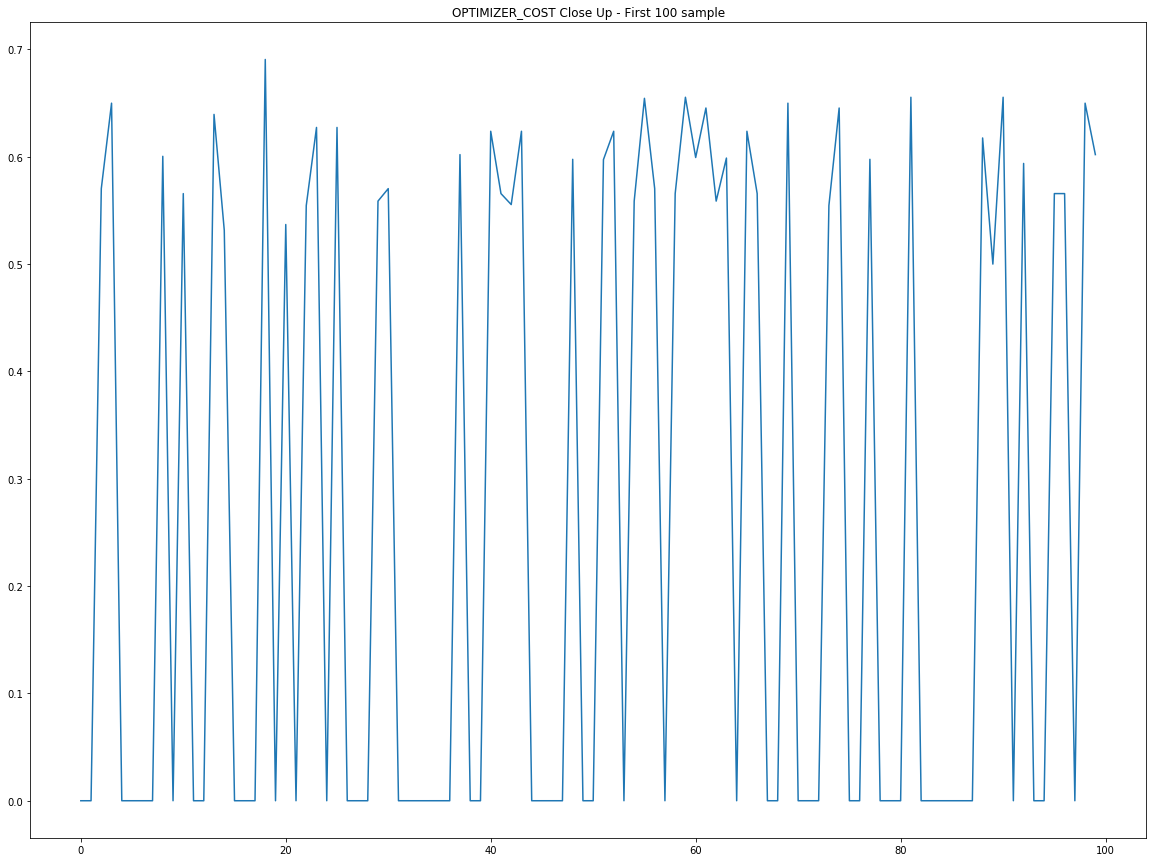

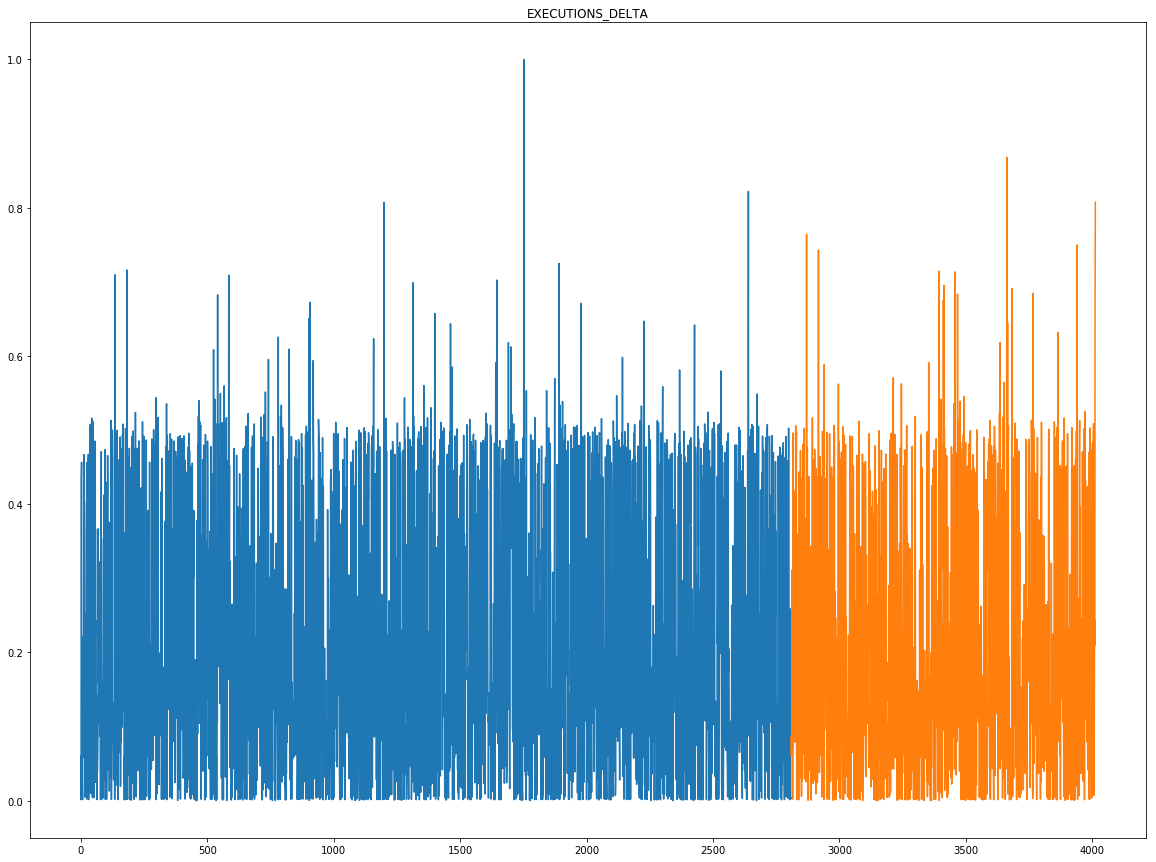

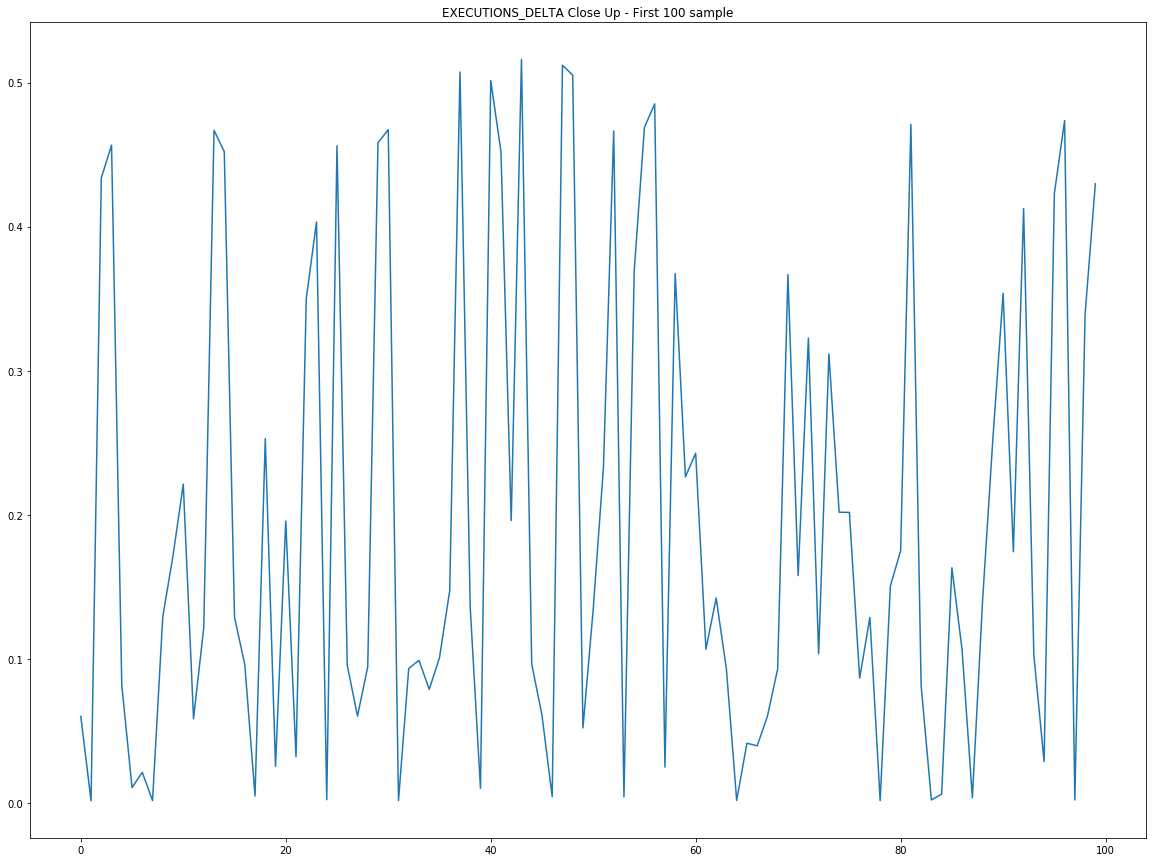

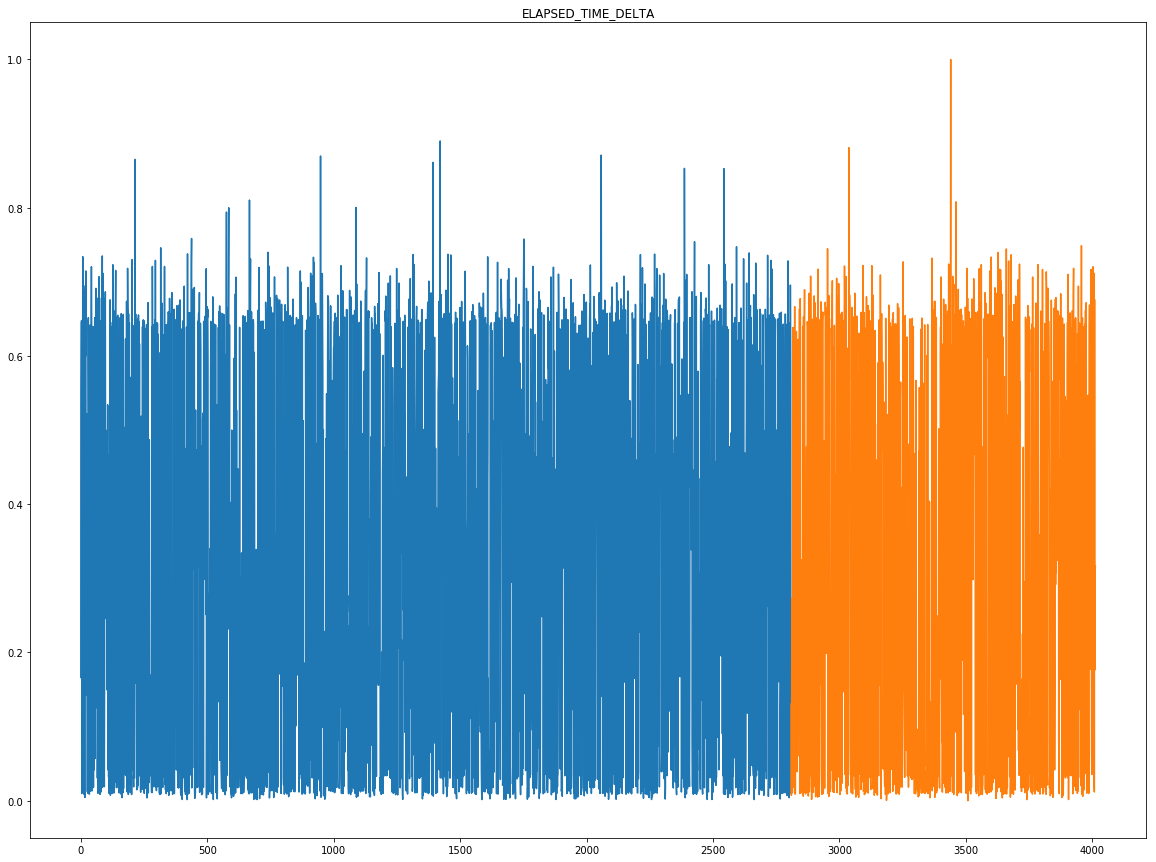

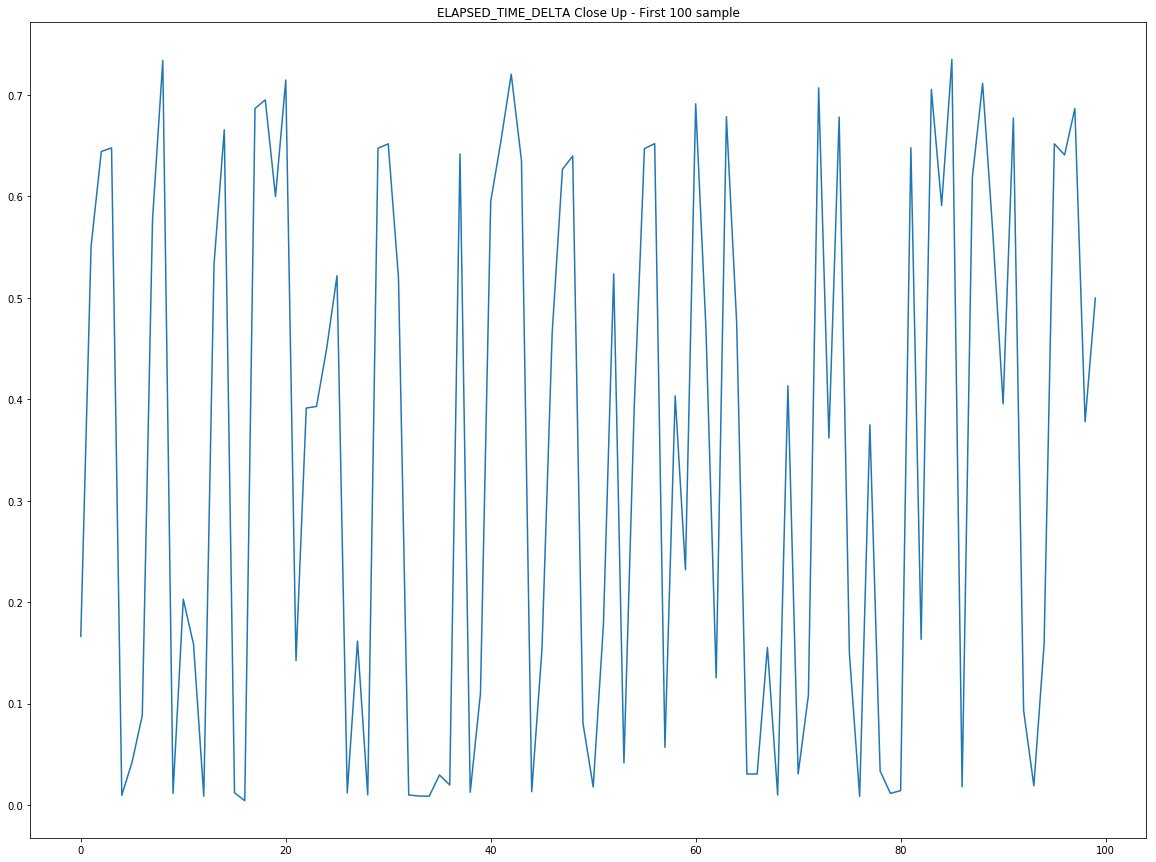


Reshaping Training Frames
X_train shape [(2809, 1, 1416)] Type - <class 'numpy.ndarray'>
X_validate shape [(602, 1, 1416)] Type - <class 'numpy.ndarray'>
X_test shape [(602, 1, 1416)] Type - <class 'numpy.ndarray'>


In [704]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
#
# Plotting label over time for train, test
# print(y_train)
# print(y_train[:,0])
for i in range(0, len(y_validate[0])):
    #
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i])
    plt.show()
    #
    # Sub-Sample (First 100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[0:sub_sample,i]])
    plt.title(y_label[i] + " Close Up - First " + str(sub_sample) + " sample")
    plt.show()
#
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))

### Designing the network

Building the LSTM Net

* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [705]:
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """
    #
    def __init__(self, X_train, y_train, layers, loss_function='mae', optimizer='adam'):
        """
        Initiating the class creates a net with the established parameters
        :param X_train - Training data used to train the model
        :param y_train - Test data used to test the model
        :param layers - A list of values, where in each value denotes a layer, and the number of neurons for that layer
        :param loss_function - Function used to measure fitting of model (predicted from actual)
        :param optimizer - Function used to optimize the model (eg: Gradient Descent)
        """
        self.model = ke.models.Sequential()
        for i in range(0,len(layers)):
            if i == 0:
                self.model.add(ke.layers.LSTM(layers[i], input_shape=(X_train.shape[1], X_train.shape[2])))
            else:
                self.model.add(ke.layers.LSTM(layers[i])) 
        self.model.add(ke.layers.Dense(y_train.shape[1]))
        self.model.compile(loss=loss_function, optimizer=optimizer)
    #
    def fit_model(self, X_train, X_test, y_train, y_test, epochs=50, batch_size=50, verbose=2, shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.
        """
        history = self.model.fit(x=X_train, 
                                 y=y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_data=(X_test,y_test), 
                                 verbose=verbose, 
                                 shuffle=shuffle)
        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='validation')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()
    #
    def predict(self, X):
        yhat = self.model.predict(X)
        return yhat
    #
    def predict_and_evaluate(self, X, y, y_labels, plot=False):
        yhat = self.predict(X)
        #
        # RMSE Evaluation
        rmse = math.sqrt(mean_squared_error(y, yhat))
        print('Test RMSE: %.3f\n-----------------------------\n\n' % rmse)
        #
        # F1-Score Evaluation
        for i in range(len(y_labels)):
            yv_c, yhat_c = [], [] 
            for val in y[:,i]:
                yv_c.append(discretize_value(amount=val))
            for val in yhat[:,i]:
                yhat_c.append(discretize_value(amount=val))
            f1 = f1_score(yv_c, yhat_c, average='micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
            print('Test FScore [' + y_labels[i] + ']: ' +  str(f1))
        #
        if plot:
            for i in range(0, len(y[0])):
                plt.rcParams['figure.figsize'] = [20, 15]
                plt.plot(y[:,i], label='actual')
                plt.plot(yhat[:,i], label='predicted')
                plt.legend(['actual', 'predicted'], loc='upper left')
                plt.title(y_labels[i])
                plt.show()

In [706]:
# model = LSTM(X_train=X_train,
#              y_train=y_train,
#              layers=[1],
#              loss_function='mae', 
#              optimizer='adam')
# model.fit_model(X_train=X_train,
#                 X_test=X_validate,
#                 y_train=y_train,
#                 y_test=y_validate,
#                 epochs=50, 
#                 batch_size=72,
#                 verbose=2, 
#                 shuffle=False,
#                 plot=True)
# model.predict_and_evaluate(X=X_validate,
#                            y=y_validate,
#                            y_labels=y_label,
#                            plot=True)

### Evaluating the Model (Walk Forward Validation / Testing)

* https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/
* https://machinelearningmastery.com/instability-online-learning-stateful-lstm-time-series-forecasting/

In [707]:
# model.fit_model(X_train=X_validate,
#                 X_test=X_test,
#                 y_train=y_validate,
#                 y_test=y_test,
#                 epochs=50, 
#                 batch_size=1,
#                 verbose=2, 
#                 shuffle=False,
#                 plot=True)
# model.predict_and_evaluate(X=X_test,
#                            y=y_test,
#                            y_labels=y_label,
#                            plot=True)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

* 0  - 10
* 11 - 20
* 21 - 30
* 31 - 40
* 41 - 50
* 51 - 60
* 61 - 70
* 71 - 80
* 81 - 90
* 91 - 100

Classify Features X into buckets of 10 (1-100% : intervals of 10%), in the attempts to convert this regression problem into one of classification.

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

X_train shape [(2809, 1416)] Type - <class 'numpy.ndarray'>
y_train shape [(2809, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(602, 1416)] Type - <class 'numpy.ndarray'>
y_validate shape [(602, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(602, 1416)] Type - <class 'numpy.ndarray'>
y_test shape [(602, 4)] Type - <class 'numpy.ndarray'>
------------------------------
[[7.08259182e-01 5.82206464e-01 5.11432896e-01 ... 0.00000000e+00
  9.50990615e-01 5.58858502e-02]
 [6.56058066e-01 6.02012437e-01 5.08405939e-01 ... 0.00000000e+00
  9.50990615e-01 6.95600476e-02]
 [1.13680020e-01 5.41326211e-08 1.85298810e-02 ... 0.00000000e+00
  9.50990615e-01 5.76694411e-02]
 ...
 [1.13893738e-02 3.59772031e-10 8.05006749e-02 ... 0.00000000e+00
  9.76016684e-01 5.80261593e-01]
 [7.99683782e-01 6.01223861e-01 2.16959136e-01 ... 0.00000000e+00
  1.33472367e-01 1.78359096e-03]
 [5.79713088e-03 3.28880113e-10 8.00507220e-02 ... 0.00000000e+00
  9.83315954e-01 7.58620690e-01]]
[[7. 5. 5. ... 0. 

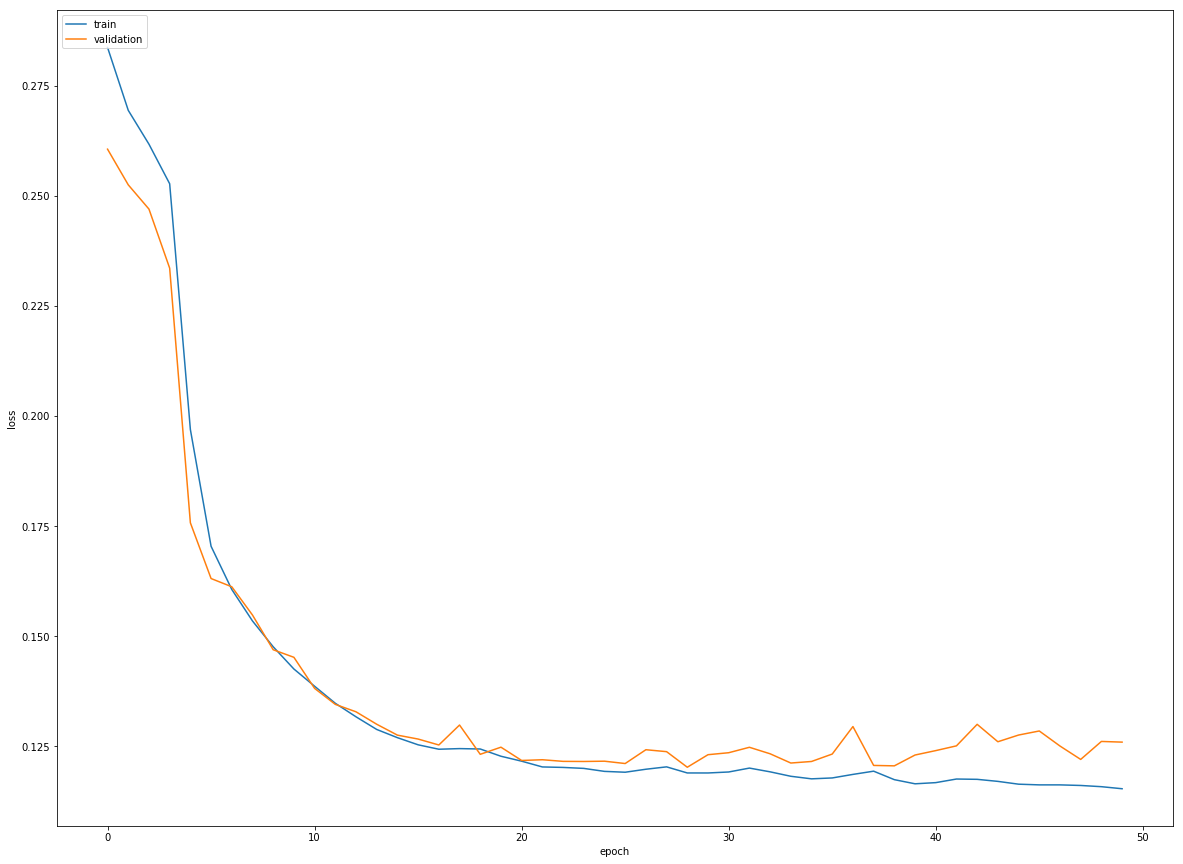

Test RMSE: 0.201
-----------------------------


Test FScore [CPU_TIME_DELTA]: 0.5232558139534884
Test FScore [OPTIMIZER_COST]: 0.1760797342192691
Test FScore [EXECUTIONS_DELTA]: 0.3089700996677741
Test FScore [ELAPSED_TIME_DELTA]: 0.5332225913621262


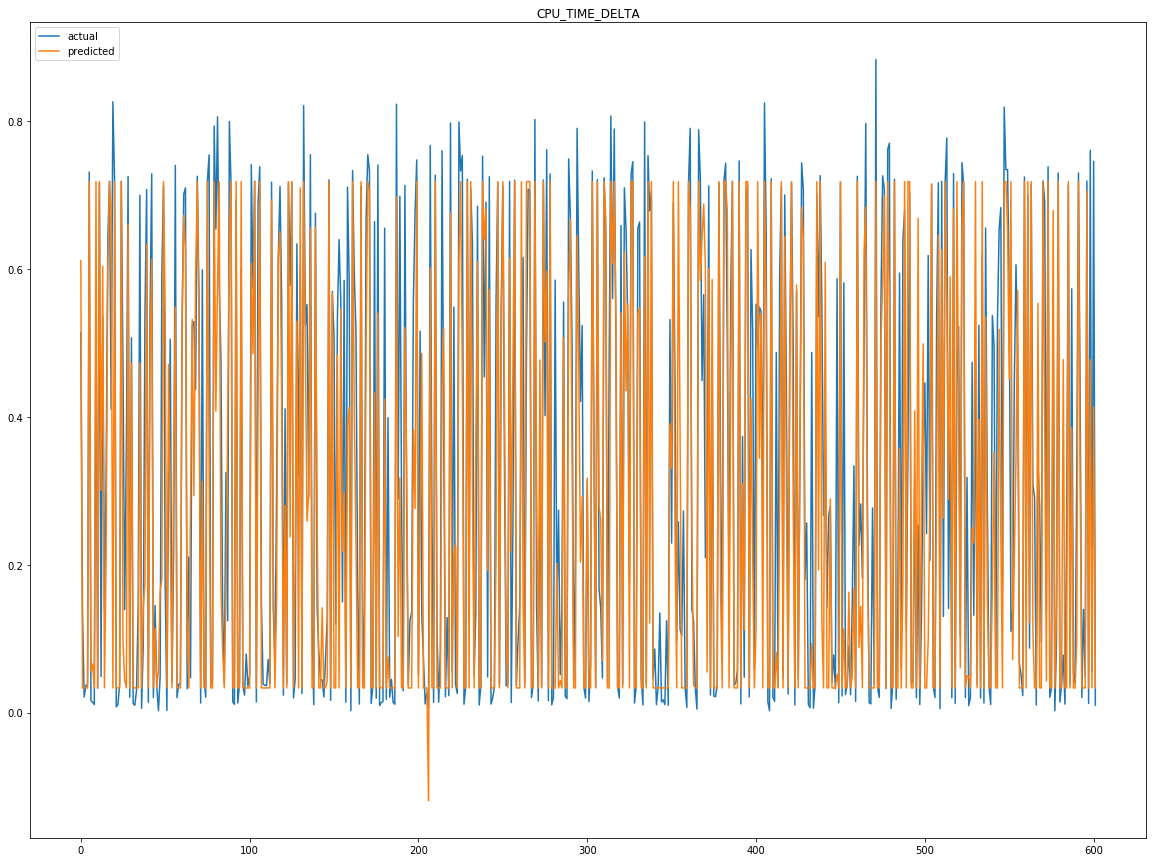

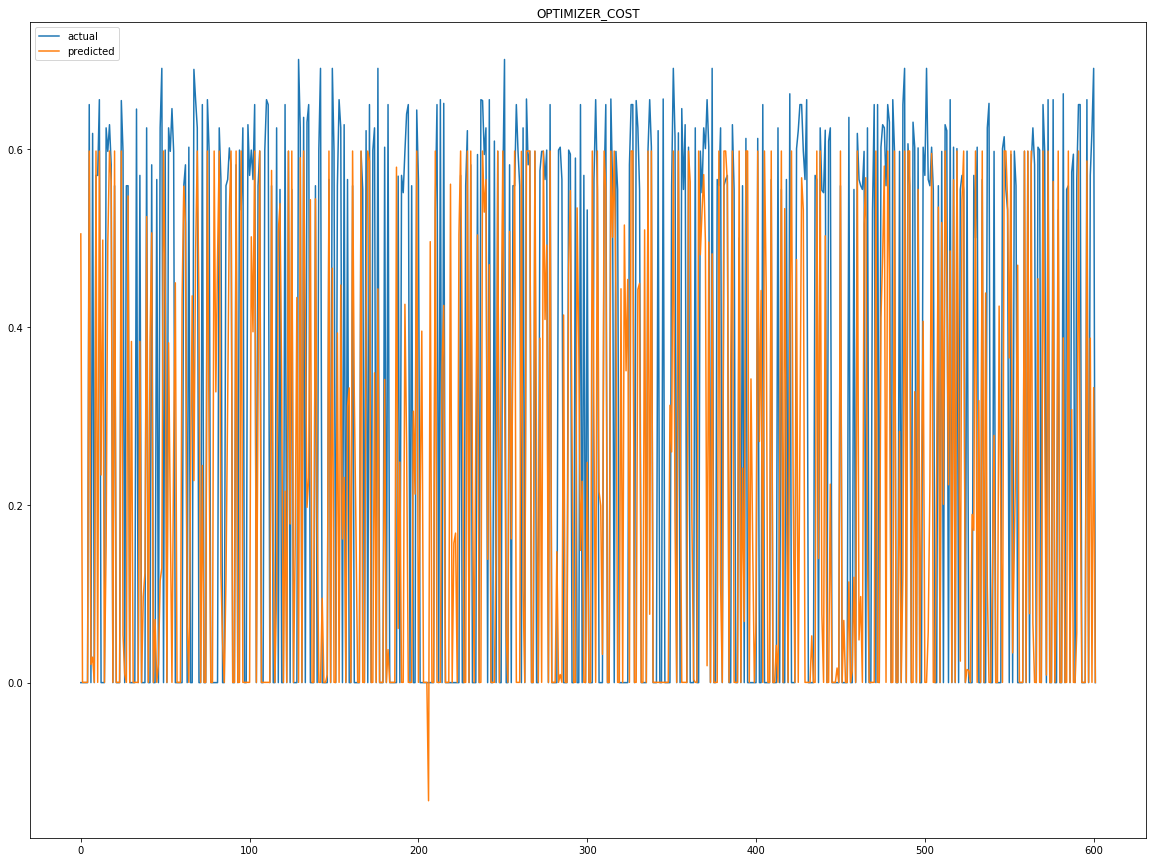

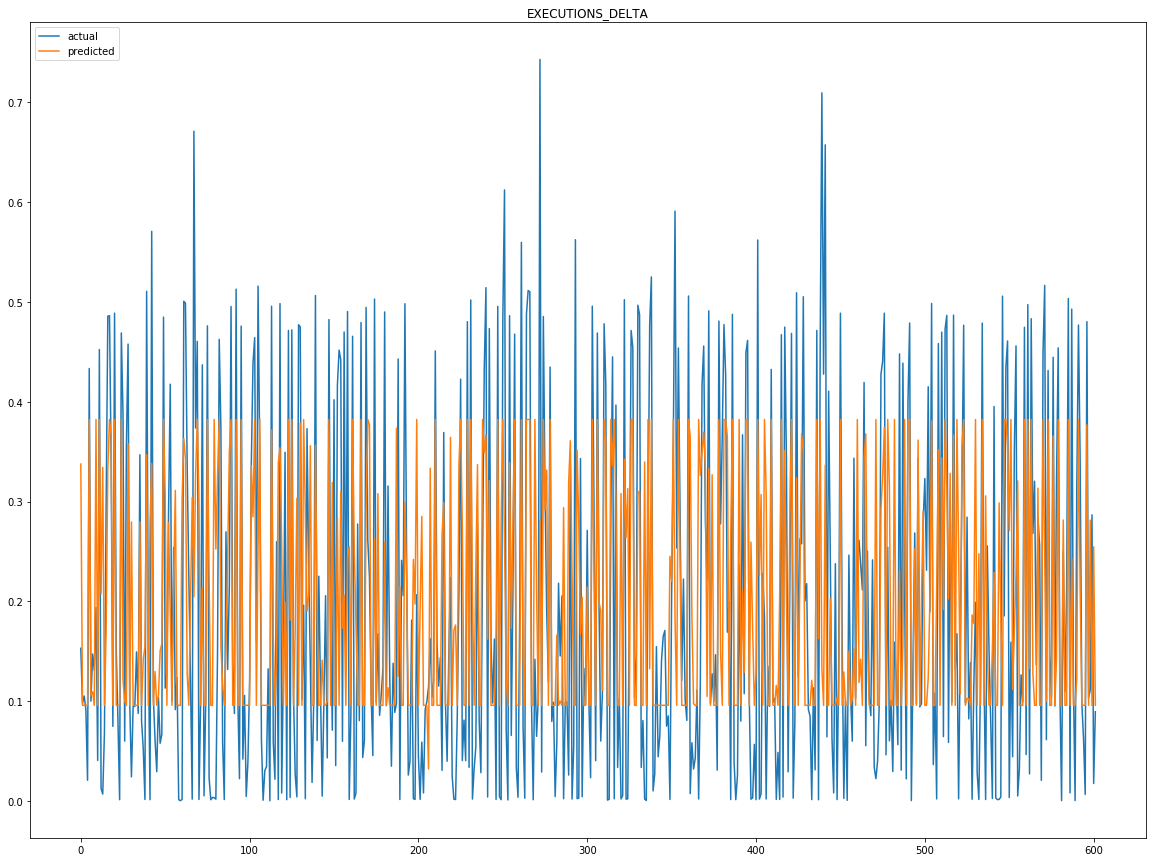

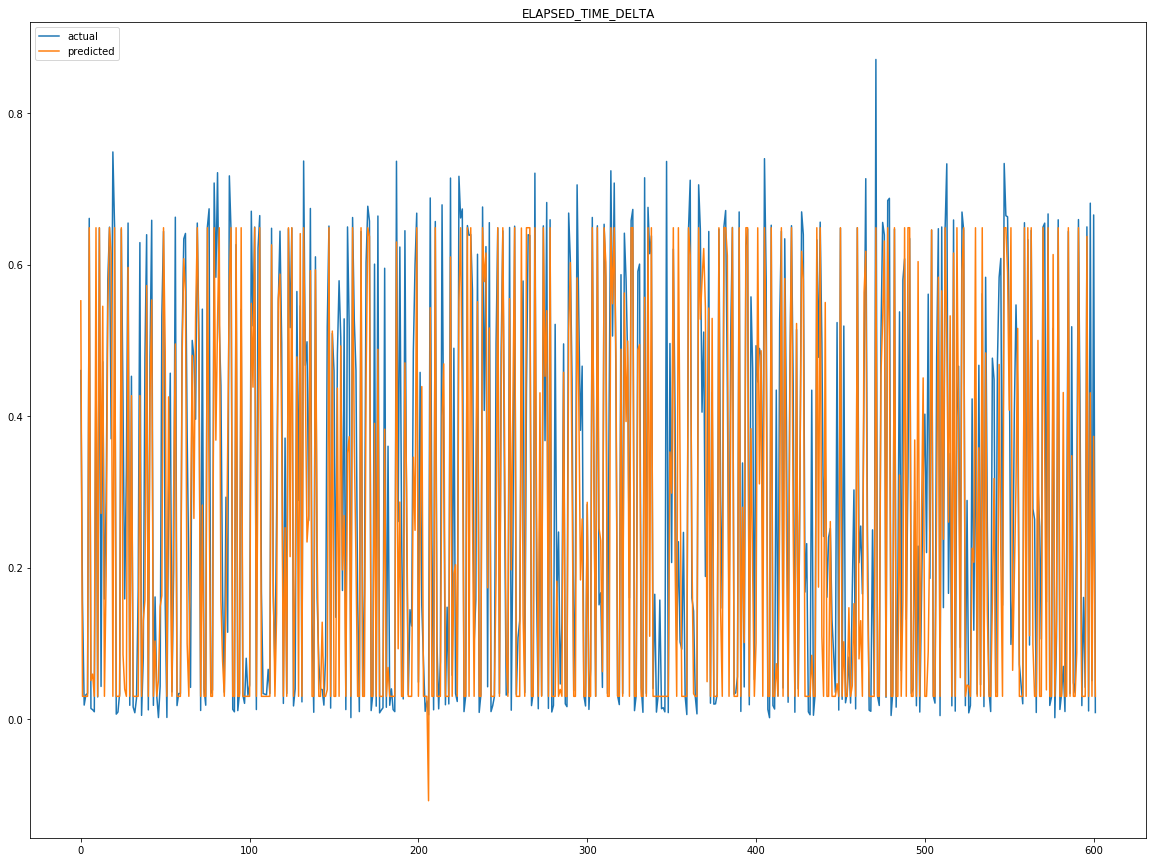

Train on 602 samples, validate on 602 samples
Epoch 1/50
 - 3s - loss: 0.2408 - val_loss: 0.2356
Epoch 2/50
 - 3s - loss: 0.2391 - val_loss: 0.2211
Epoch 3/50
 - 4s - loss: 0.2186 - val_loss: 0.1738
Epoch 4/50
 - 3s - loss: 0.1711 - val_loss: 0.1523
Epoch 5/50
 - 3s - loss: 0.1761 - val_loss: 0.1498
Epoch 6/50
 - 3s - loss: 0.1519 - val_loss: 0.2045
Epoch 7/50
 - 3s - loss: 0.1484 - val_loss: 0.1547
Epoch 8/50
 - 3s - loss: 0.1479 - val_loss: 0.1465
Epoch 9/50
 - 3s - loss: 0.1474 - val_loss: 0.1491
Epoch 10/50
 - 3s - loss: 0.1462 - val_loss: 0.1577
Epoch 11/50
 - 3s - loss: 0.1454 - val_loss: 0.1445
Epoch 12/50
 - 3s - loss: 0.1394 - val_loss: 0.1489
Epoch 13/50
 - 3s - loss: 0.1466 - val_loss: 0.1465
Epoch 14/50
 - 3s - loss: 0.1445 - val_loss: 0.1460
Epoch 15/50
 - 3s - loss: 0.1391 - val_loss: 0.1439
Epoch 16/50
 - 3s - loss: 0.1380 - val_loss: 0.1470
Epoch 17/50
 - 3s - loss: 0.1460 - val_loss: 0.1457
Epoch 18/50
 - 3s - loss: 0.1380 - val_loss: 0.1438
Epoch 19/50
 - 3s - loss: 0

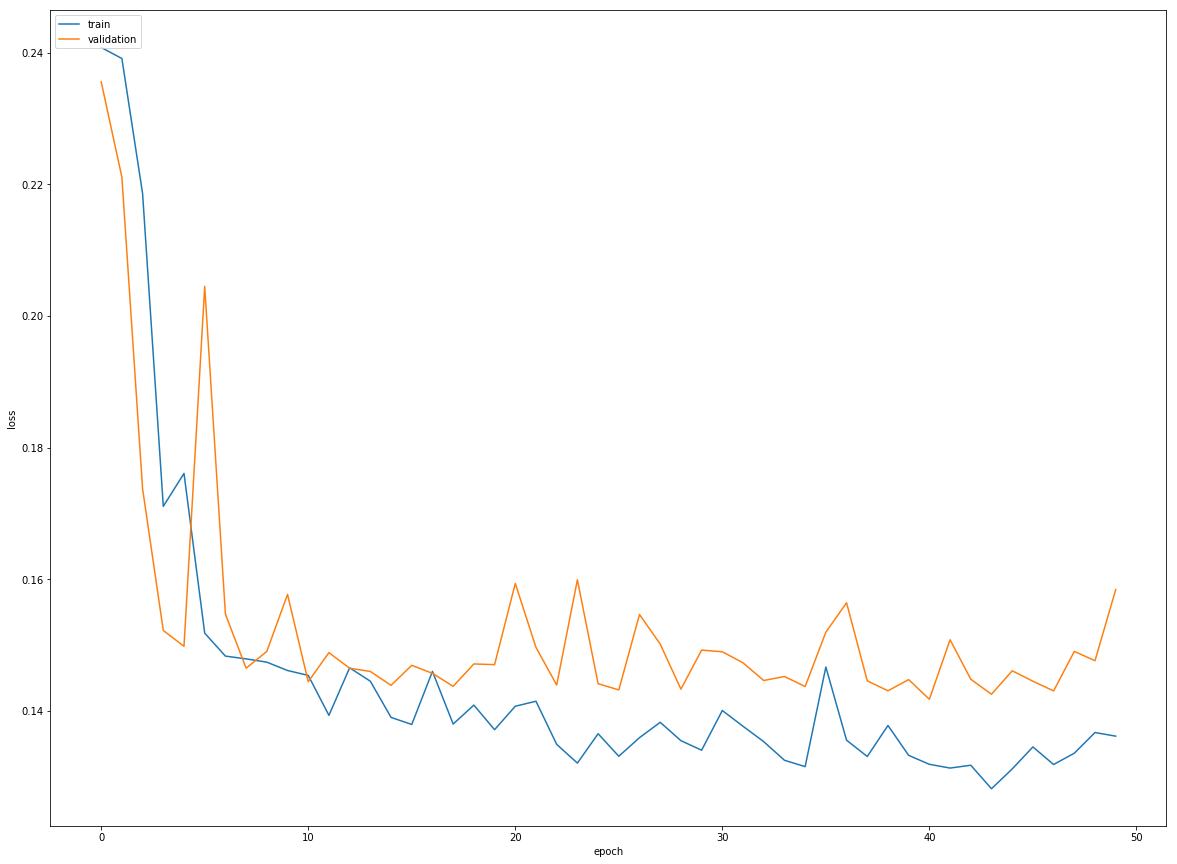

Test RMSE: 0.252
-----------------------------


Test FScore [CPU_TIME_DELTA]: 0.4219269102990033
Test FScore [OPTIMIZER_COST]: 0.1511627906976744
Test FScore [EXECUTIONS_DELTA]: 0.22093023255813954
Test FScore [ELAPSED_TIME_DELTA]: 0.5415282392026578


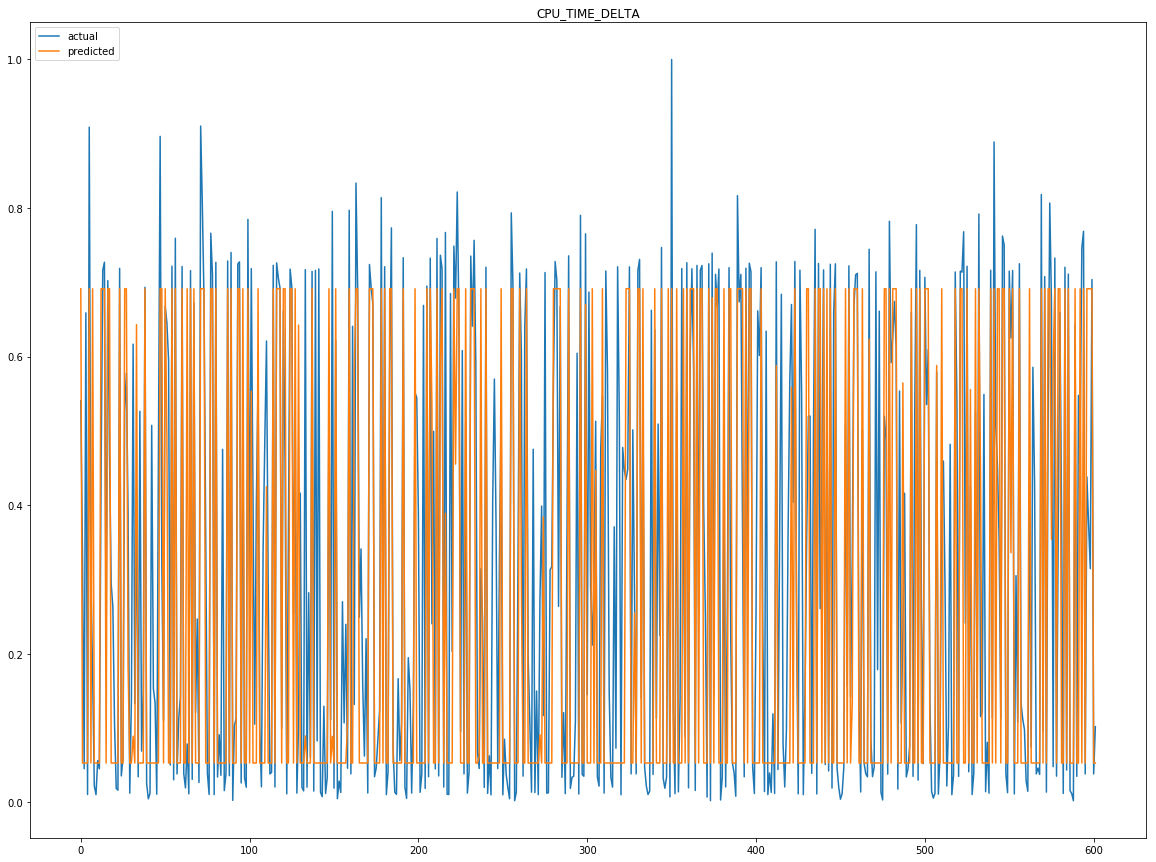

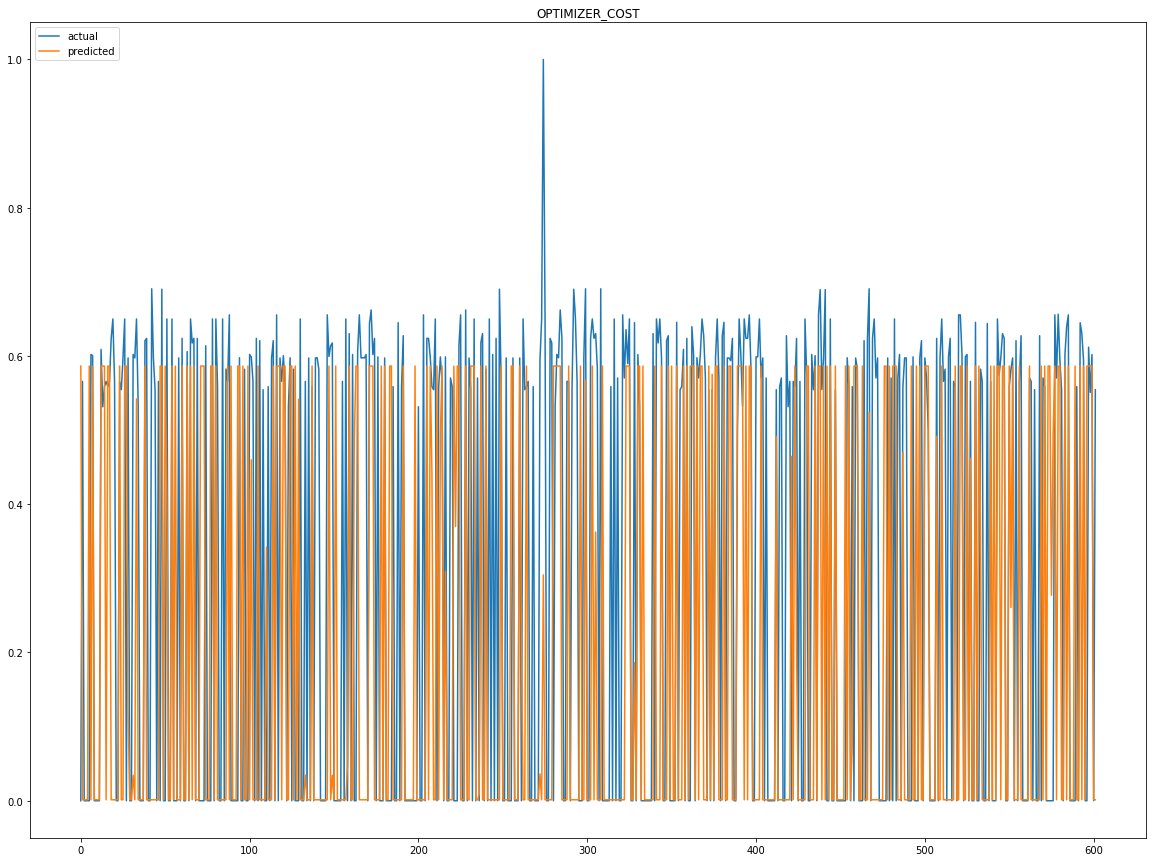

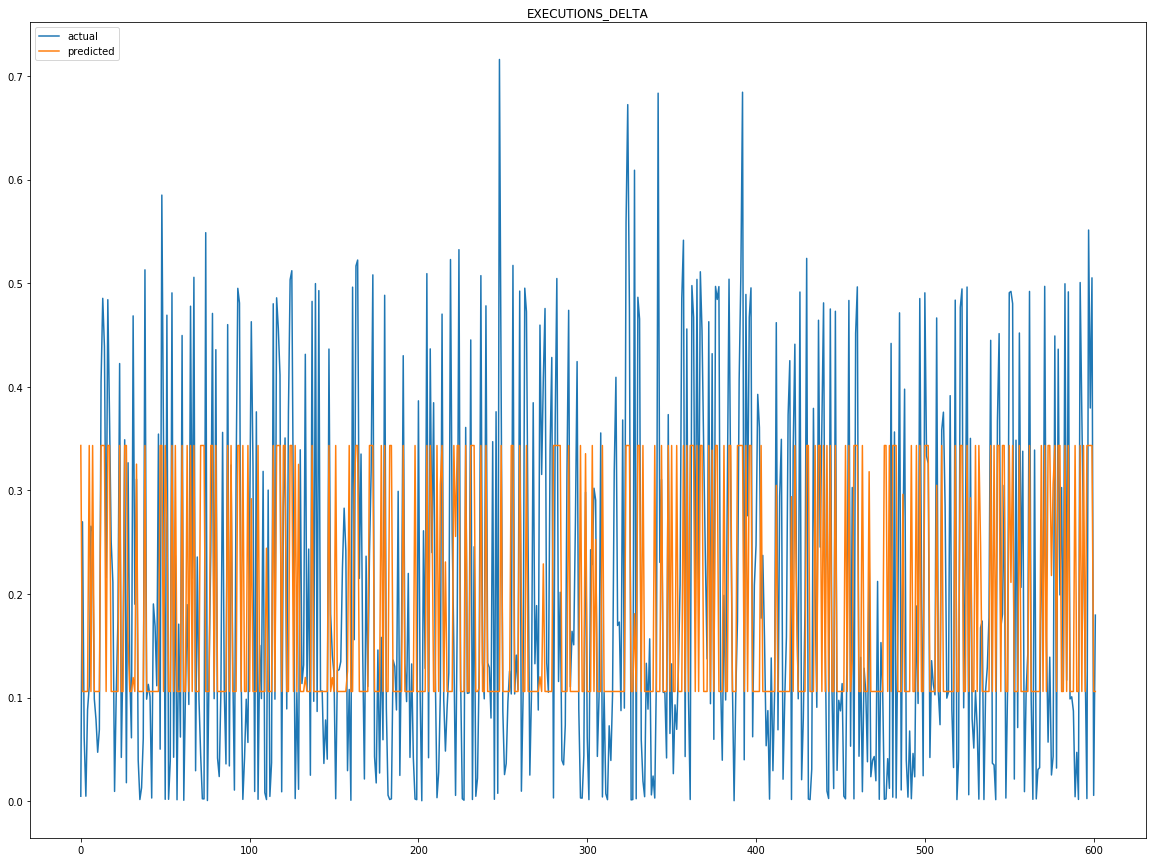

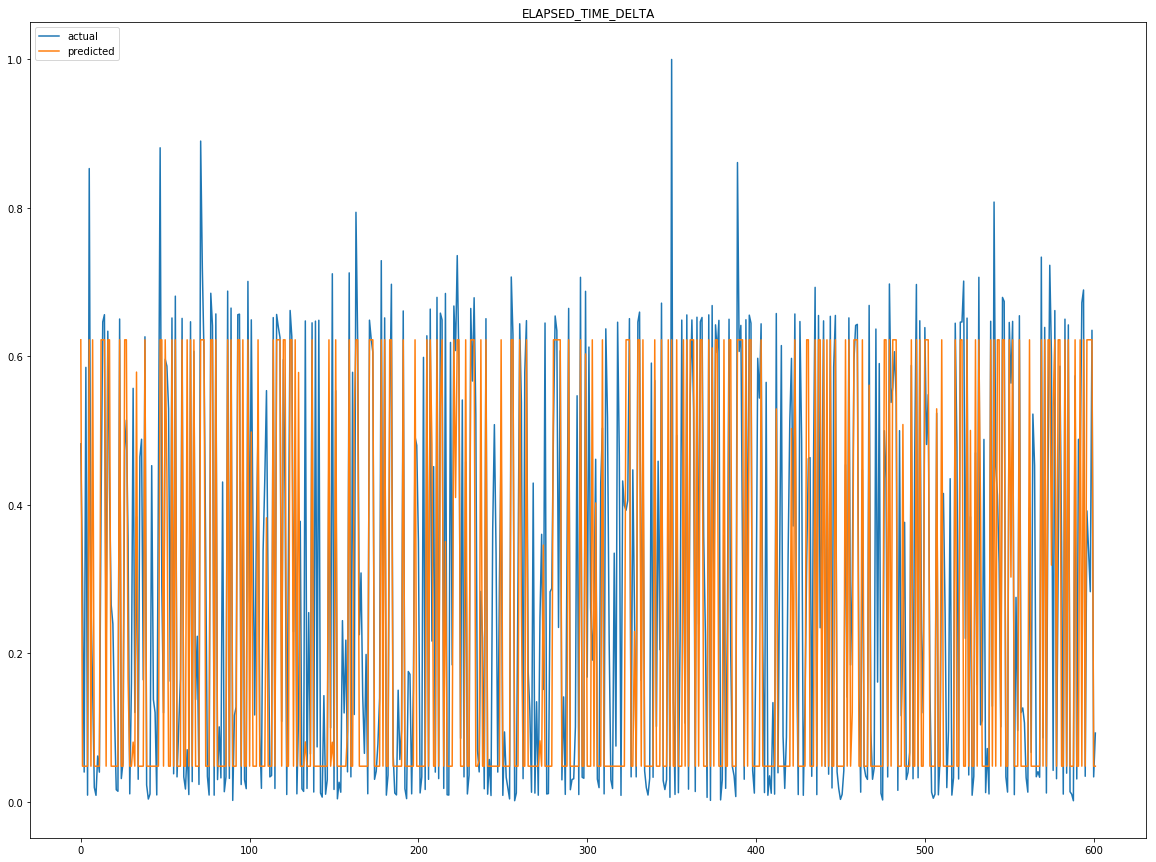

In [711]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")
#
# Map Discretize function to matrices
vecfunc = np.vectorize(discretize_value)
print(X_train)
X_train=vecfunc(X_train)
print(X_train)
print('------------------------------------------------------------')
print(X_validate)
X_validate=vecfunc(X_validate)
print(X_validate)
print('------------------------------------------------------------')
print(X_test)
X_test=vecfunc(X_test)
print(X_test)
#
# Reshape for fitting in LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
#
# Train on discrete data (Train > Validation)
discrete_model = LSTM(X_train=X_train,
                      y_train=y_train,
                      layers=[1],
                      loss_function='mae', 
                      optimizer='adam')
discrete_model.fit_model(X_train=X_train,
                         X_test=X_validate,
                         y_train=y_train,
                         y_test=y_validate,
                         epochs=50, 
                         batch_size=72,
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_validate,
                                    y=y_validate,
                                    y_labels=y_label,
                                    plot=True)
#
# Train on discrete data (Train + Validation > Test)
discrete_model.fit_model(X_train=X_validate,
                         X_test=X_test,
                         y_train=y_validate,
                         y_test=y_test,
                         epochs=50, 
                         batch_size=1,
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_test,
                                    y=y_test,
                                    y_labels=y_label,
                                    plot=True)